In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
!pip install hmmlearn

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 153kB 5.0MB/s 
  Created wheel for hmmlearn: filename=hmmlearn-0.2.2-cp36-cp36m-linux_x86_64.whl size=325114 sha256=9b0c796e97ec816b56127b2a3a7611bd7dd9e13e90fa75cc6debc6274d606eea
  Stored in directory: /root/.cache/pip/wheels/2c/b6/0e/63a865a30e21e01d04f417d8995fbfb793d6bd464707efc546
Successfully built hmmlearn


In [0]:
from scipy import signal
from librosa.feature import mfcc
from librosa.feature import delta

### MFCC using librosa...mfcc
def get_mfcc(y, samp_rate, k=13):
  # print(len(y))
  mfcc_coeff = mfcc(y,samp_rate,n_mfcc=k)
  mfcc_delta1 = delta(mfcc_coeff, width=5, order = 1)
  mfcc_delta2 = delta(mfcc_coeff, width=5, order = 2) ## k doesn't work
  return np.concatenate((mfcc_coeff,mfcc_delta1,mfcc_delta2), axis=0)


Load data and store vectors with end-pointing and pre-emphasis.

In [0]:
import os
import pickle
from librosa.effects import trim
from scipy.io import wavfile
### Load and store Data
def load(flag,num_samp):
  for root,subdir,files in os.walk('/content/drive/My Drive/CA3_Commands_Dataset' + '/{}'.format(flag)):
    if(files == []):
      word = subdir
      continue
    dump = []
    print(flag,root,word)
    for file_ in files[:num_samp]:
      samp_rate,y = wavfile.read('{}/{}'.format(root,file_))
      end_pt,idx = trim(y.astype(np.float))
      # print(len(end_pt),len(y))
      # print(samp_rate)
      end_pt = signal.lfilter([1,-0.95], [1], end_pt)
      dump.append(get_mfcc(end_pt, samp_rate=samp_rate, k=13))
    with open('{}/{}_{}.pkl'.format('/content/drive/My Drive/quick_load',flag,root.split('/')[-1]), 'wb+') as dst:
      pickle.dump(dump,dst)
      # print(len(dump[0]))
  return

In [0]:
# load('train',500)

In [0]:
# load('test_clean',100)

In [0]:
### Training
from hmmlearn import hmm

words = ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
def training(words,trainset):
  models = []
  for word in words:
    print(word)
    v_file = open('/content/drive/My Drive/quick_load/{}_{}.pkl'.format(trainset,word),'rb')
    vectors = pickle.load(v_file)
    # print(len(vectors))
    lcols = [vectors[0].shape[1]]
    X = np.transpose(vectors[0])
    for vector in vectors[1:]:
      lcols.append(vector.shape[1])
      X = np.concatenate((X,np.transpose(vector)),axis=0)
    # print(,vec)
    model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=50)
    model.fit(X,lcols)
    # print(model)
    # print(model.monitor_.converged)
    models.append(model)
  return models



In [173]:
models = training(words,'train')
# print(models)

go
left
yes
off
right
stop
no
down
up
on


In [0]:
 with open('/content/drive/My Drive/quick_load/train_models.pkl', 'wb+') as dst:
      pickle.dump(models,dst)

In [0]:
def testing(testset,models,words):
  accuracy = []
  heat_map = []
  for word in words:
    v_file = open('/content/drive/My Drive/quick_load'+'/{}_{}.pkl'.format(testset,word),'rb')
    vectors = pickle.load(v_file)
    correct_count = 0
    tc = 0
    heat = np.zeros(len(words))
    for vector in vectors:
      tc += 1
      vector = np.transpose(vector)
      scores = []
      for i in range(len(words)):
        r = models[i].score(vector)
        scores.append(models[i].score(vector))
      # print(len(scores))
      if(np.argmax(np.array(scores)) == words.index(word)):
        correct_count +=1
      heat[np.argmax(np.array(scores))] += 1
    w_accuracy = 100*correct_count/tc
    accuracy.append(w_accuracy)
    heat_map.append(heat)
    print('Accuracy for ',word,' : ',w_accuracy,'%')
  print('Overall Accuracy : ', sum(accuracy)/len(accuracy),'%')
  return heat_map

In [176]:
# models
# t_models = models
# for i in range(len(words)-1):
#   t_models = t_models.append(models[0])
heat_map = testing('test_clean',models,words)

Accuracy for  go  :  71.0 %
Accuracy for  left  :  85.6 %
Accuracy for  yes  :  93.2 %
Accuracy for  off  :  81.2 %
Accuracy for  right  :  86.4 %
Accuracy for  stop  :  82.3293172690763 %
Accuracy for  no  :  75.6 %
Accuracy for  down  :  70.0 %
Accuracy for  up  :  82.4 %
Accuracy for  on  :  82.52032520325203 %
Overall Accuracy :  81.02496424723282 %


In [0]:
### Confusion Matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

def confusion_matrix(heat_map,testset,words):
  df_cm = pd.DataFrame(heat_map, index = [word for word in words], columns = [word for word in words])
  plt.figure(figsize=(12,8))
  plt.xlabel('Predicted Word')
  plt.ylabel('Actual Word')
  plt.title('Confusion Matrix for {}'.format(testset))
  sn.set(font_scale=1.4)#for label size
  cmap = sn.cm.rocket_r
  
  ### Y-axis = Actual Label
  ### X-axis = Predicted Label
   
  sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap=cmap)
  plt.show()


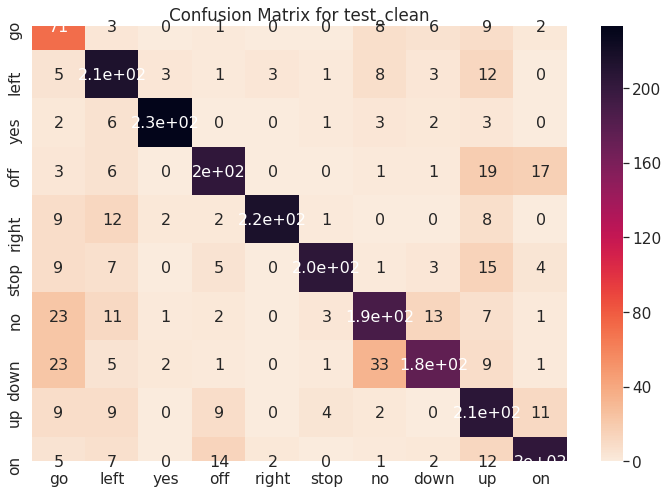

In [200]:
confusion_matrix(heat_map,'test_clean',words)

In [196]:
heat_map_noisy_with_clean_training = testing('test_noisy',models,words)

Accuracy for  go  :  48.0 %
Accuracy for  left  :  58.0 %
Accuracy for  yes  :  94.0 %
Accuracy for  off  :  90.8 %
Accuracy for  right  :  55.6 %
Accuracy for  stop  :  42.16867469879518 %
Accuracy for  no  :  42.8 %
Accuracy for  down  :  39.2 %
Accuracy for  up  :  49.2 %
Accuracy for  on  :  47.96747967479675 %
Overall Accuracy :  56.773615437359204 %


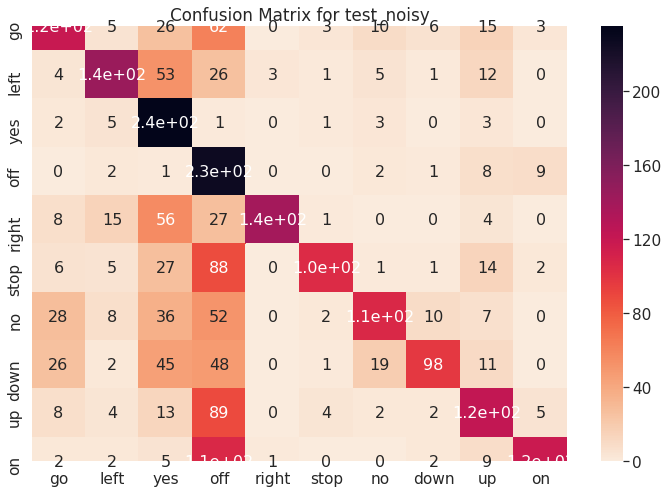

In [201]:
confusion_matrix(heat_map_noisy_with_clean_training,'test_noisy',words)

In [0]:
import random
def noisyload(num_samp):
  flag = 'train'
  noise_choices = os.listdir('/content/drive/My Drive/CA3_Commands_Dataset/_background_noise_')
  for root,subdir,files in os.walk('/content/drive/My Drive/CA3_Commands_Dataset' + '/{}'.format(flag)):
    if(files == []):
      word = subdir
      continue
    dump = []
    print(flag,root,word)
    for file_ in files[:num_samp]:
      noise_choice = np.random.choice(noise_choices,1)
      samp_rate,noise = wavfile.read('/content/drive/My Drive/CA3_Commands_Dataset/_background_noise_/{}'.format(noise_choice[0]))
      samp_rate,y = wavfile.read('{}/{}'.format(root,file_))
      speech,idx = trim(y.astype(np.float))
      
      numSamples = len(speech)

      #clipping a segment of noise from a random position, with segment length equal to the length of speech 
      i = np.random.choice(np.arange(len(noise) - numSamples))
      noise = noise[i:i+numSamples]

      #converting the PCM values to floats with range from -1.0 to 1.0
      speech = speech/32768
      noise = noise/32768

      #normalizing the noise and adding it to the speech
      rawEnergy = np.sum(speech**2)
      noise = noise*(np.sqrt(rawEnergy/(10*np.sum(noise**2))))
      # 0.5 probability of noise addition
      if(random.random() > 0.49):
        speech = speech + noise
      else:
        speech = speech
      #normalizing the noisy speech so that its energy equals the energy of raw speech
      speech = speech*(np.sqrt(rawEnergy/np.sum(speech**2)))

      #converting the floats back to PCM values
      speech = speech*32767
      speech = speech.astype(np.int16)

      
      # print(len(end_pt),len(y))
      # print(samp_rate)
      speech = signal.lfilter([1,-0.95], [1], speech)
      dump.append(get_mfcc(speech, samp_rate=samp_rate, k=13))
    with open('{}/noisytrain_{}.pkl'.format('/content/drive/My Drive/quick_load',root.split('/')[-1]), 'wb+') as dst:
      pickle.dump(dump,dst)
      # print(len(dump[0]))
  return

In [142]:
## Loading 50% Noisy training data
# noisyload(2000)

train /content/drive/My Drive/CA3_Commands_Dataset/train/go ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']


/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


train /content/drive/My Drive/CA3_Commands_Dataset/train/left ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
train /content/drive/My Drive/CA3_Commands_Dataset/train/yes ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
train /content/drive/My Drive/CA3_Commands_Dataset/train/off ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
train /content/drive/My Drive/CA3_Commands_Dataset/train/right ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
train /content/drive/My Drive/CA3_Commands_Dataset/train/stop ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
train /content/drive/My Drive/CA3_Commands_Dataset/train/no ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
train /content/drive/My Drive/CA3_Commands_Dataset/train/down ['go', 'left', 'yes', 'off', 'right', 'stop', 'no', 'down', 'up', 'on']
train /content/drive/My Drive/CA3_Commands_Dataset/train/up ['go'

In [0]:
def noisy_training(words,trainset):
  models = []
  for word in words:
    print(word)
    v_file = open('/content/drive/My Drive/quick_load/{}_{}.pkl'.format(trainset,word),'rb')
    vectors = pickle.load(v_file)
    # print(len(vectors))
    lcols = [vectors[0].shape[1]]
    X = np.transpose(vectors[0])
    for vector in vectors[1:]:
      lcols.append(vector.shape[1])
      X = np.concatenate((X,np.transpose(vector)),axis=0)
    # print(,vec)
    model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=50)
    model.fit(X,lcols)
    # print(model)
    # print(model.monitor_.converged)
    models.append(model)
  return models


In [203]:
noisy_models = noisy_training(words,'noisytrain')


go
left
yes
off
right
stop
no
down
up
on


In [0]:
with open('/content/drive/My Drive/quick_load/noisytrain_models.pkl', 'wb+') as dst:
  pickle.dump(noisy_models,dst)

In [205]:
noisy_heat_map = testing('test_noisy',noisy_models,words)

Accuracy for  go  :  66.4 %
Accuracy for  left  :  74.0 %
Accuracy for  yes  :  87.2 %
Accuracy for  off  :  63.6 %
Accuracy for  right  :  87.2 %
Accuracy for  stop  :  81.52610441767068 %
Accuracy for  no  :  66.8 %
Accuracy for  down  :  69.6 %
Accuracy for  up  :  68.0 %
Accuracy for  on  :  76.01626016260163 %
Overall Accuracy :  74.03423645802724 %


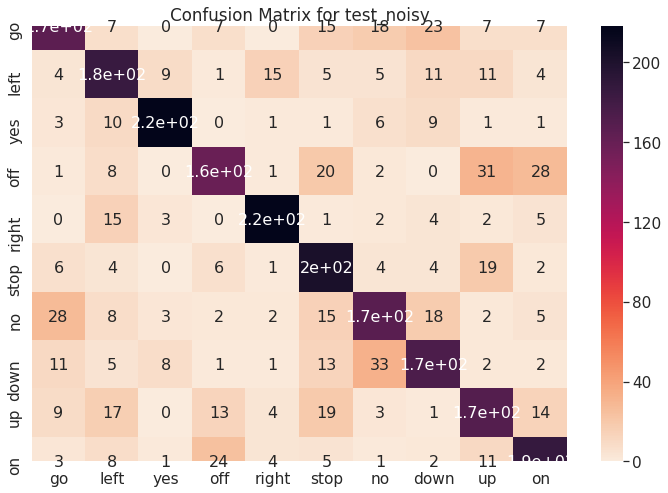

In [207]:
confusion_matrix(noisy_heat_map,'test_noisy',words)

In [208]:
### Clean test data on noisy training
noisy_heat_map_with_clean_test_data = testing('test_clean',noisy_models,words)

Accuracy for  go  :  77.6 %
Accuracy for  left  :  83.2 %
Accuracy for  yes  :  92.8 %
Accuracy for  off  :  65.2 %
Accuracy for  right  :  86.4 %
Accuracy for  stop  :  86.34538152610442 %
Accuracy for  no  :  73.6 %
Accuracy for  down  :  74.4 %
Accuracy for  up  :  74.4 %
Accuracy for  on  :  71.13821138211382 %
Overall Accuracy :  78.50835929082182 %
